In [1]:
import torch
from torch import nn
from lib.nursing import *
from lib.utils import *
from lib.models import ResNet
def puff_state_machine(predictions):
    ret = predictions.clone()
    state = 0
    states = []
    puff_locations = []
    currentInterPuffIntervalLength = 0
    currentPuffLength = 0
    puff_start = 0
    for i,smokingOutput in enumerate(predictions):
        states.append(state)
        if (state == 0 and smokingOutput == 0.0):
            # no action
            state = 0
        elif (state == 0 and smokingOutput == 1.0):
            # starting validating puff length
            state = 1
            currentPuffLength += 1
            puff_start = i
        elif (state == 1 and smokingOutput == 1.0):
            # continuing not yet valid length puff
            currentPuffLength += 1
            if (currentPuffLength > 14) :
                # valid puff length!
                state = 2
        elif (state == 1 and smokingOutput == 0.0):
            # never was a puff, begin validating end
            state = 3
            currentInterPuffIntervalLength += 1
        elif (state == 2 and smokingOutput == 1.0):
            # continuing already valid puff
            currentPuffLength += 1
        elif (state == 2 and smokingOutput == 0.0):
            # ending already valid puff length
            state = 4 # begin validating inter puff interval
            currentInterPuffIntervalLength += 1
        elif (state == 3 and smokingOutput == 0.0): 
            currentInterPuffIntervalLength += 1
            if (currentInterPuffIntervalLength > 30):
                # valid interpuff
                state = 0
                currentPuffLength = 0
                currentInterPuffIntervalLength = 0
                ret[puff_start:i-30] = 0
        elif (state == 3 and smokingOutput == 1.0):
            # was validating interpuff for puff that wasn't valid
            currentPuffLength += 1
            currentInterPuffIntervalLength = 0
            if (currentPuffLength > 14) :
                # valid puff length!
                state = 2
            else:
                state = 1
        elif (state == 4 and smokingOutput == 0.0) :
            currentInterPuffIntervalLength += 1
            if (currentInterPuffIntervalLength > 30):
                # valid interpuff for valid puff
                state = 0
                currentPuffLength = 0
                currentInterPuffIntervalLength = 0
                puff_locations.append(i)
                ret[puff_start:i-30] = 1
        elif (state == 4 and smokingOutput == 1.0):
            # back into puff for already valid puff
            currentInterPuffIntervalLength = 0
            currentPuffLength += 1
            state = 2
    states = states[1:] + [0]
    return states,puff_locations,ret
def stats(y_pred):
    y_pred = y_pred.squeeze().long()
    current_state = y_pred[0].item()
    current_length = 1
    states = {
        0:[],
        1:[]
    }
    for epoch in y_pred[1:]:
        if epoch != current_state:
            states[current_state].append(current_length)
            current_state = epoch.item()
            current_length = 0
        current_length += 1
    states[current_state].append(current_length)
    puff_bouts = states[1]
    puff_count = len(puff_bouts)
    average_puff_duration = np.mean(puff_bouts)
    total_puff_duration = np.sum(puff_bouts)
    return pd.DataFrame([puff_count,average_puff_duration,total_puff_duration],index=['puff count','average puff duration','total puff duration']).T

In [4]:
all_metrics = pd.DataFrame()
all_stats = pd.DataFrame()
criterion = nn.BCEWithLogitsLoss()

In [ ]:

for foldi in range(1):
    model = ResNet()
    model.load_state_dict(torch.load(f'../projects/res_cv_{foldi}/best_model.pt'))
    test_idx = load_cv_test_idx(foldi=foldi)

    for i in test_idx[:5]:
        X,y = load_and_window_nursing_list_for_convolution([i])
        testloader = DataLoader(TensorDataset(X,y),batch_size=32,shuffle=False)
        loss,metric,y_true,y_pred,y_logits = evaluate(testloader,model,criterion)
        _,_,y_pred_expert = puff_state_machine(y_pred)
        all_metrics = pd.concat([all_metrics,pd.Series(metric,name=f'{i}')],axis=1)
        all_stats = pd.concat([all_stats,pd.concat([stats(y_true).rename({'puff count':'true puff count','average puff duration':'true average puff duration','total puff duration':'true total puff duration'},axis=1),stats(y_pred).rename({'puff count':'pred puff count','average puff duration':'pred average puff duration','total puff duration':'pred total puff duration'},axis=1),stats(y_pred_expert).rename({'puff count':'expert puff count','average puff duration':'expert average puff duration','total puff duration':'expert total puff duration'},axis=1)],axis=1)],axis=0)

In [4]:
all_metrics.T.describe()

,precision,recall,f1
count,5.000000,5.000000,5.000000
mean,0.852233,0.869102,0.854876
std,0.079320,0.026912,0.042438
min,0.745573,0.843555,0.800626
25%,0.795310,0.846909,0.818721
50%,0.890227,0.859663,0.874329
75%,0.890326,0.893960,0.884965
max,0.939727,0.901424,0.895739


In [5]:
all_stats.index = list(all_metrics.T.reset_index()['index'])
all_stats = all_stats[all_stats['true puff count'] > 8]

In [6]:
all_metrics[list(all_stats.reset_index()['index'])].T.describe()

,precision,recall,f1
count,5.000000,5.000000,5.000000
mean,0.852233,0.869102,0.854876
std,0.079320,0.026912,0.042438
min,0.745573,0.843555,0.800626
25%,0.795310,0.846909,0.818721
50%,0.890227,0.859663,0.874329
75%,0.890326,0.893960,0.884965
max,0.939727,0.901424,0.895739


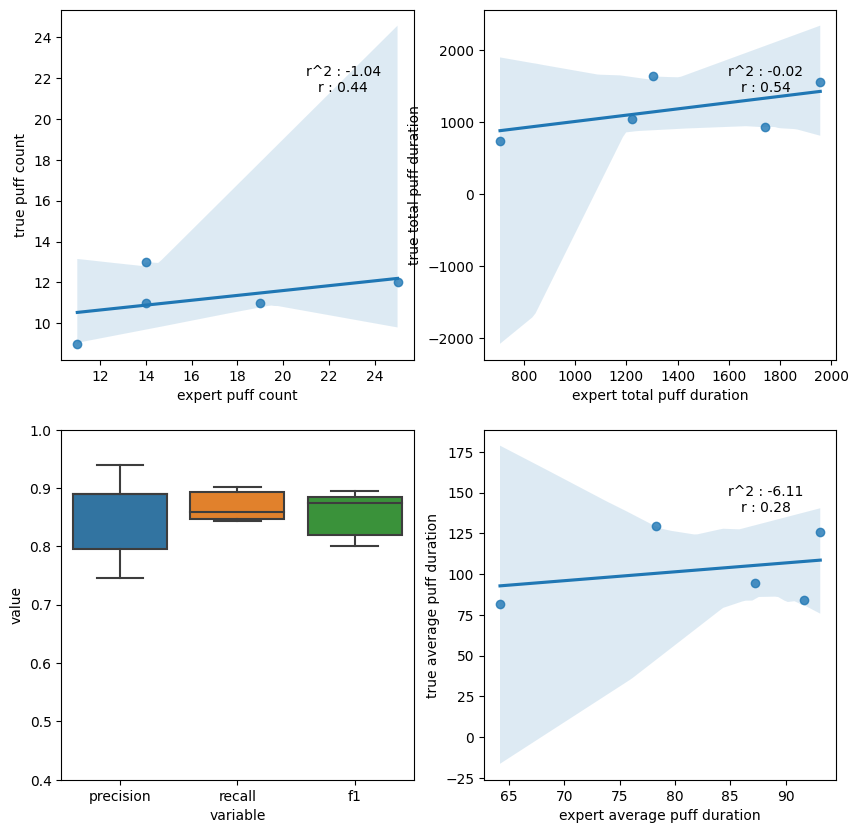

In [7]:
import seaborn as sns
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
fig,axes = plt.subplots(nrows=2,ncols=2,figsize=(10,10))

x = 'expert puff count'
y = 'true puff count'
sns.regplot(data=all_stats,x=x,y=y,ax=axes[0,0])
axes[0,0].set_xlabel(x)
axes[0,0].set_ylabel(y)
axes[0,0].text(0.8, 0.8, f'r^2 : {r2_score(all_stats[x],all_stats[y]):.2f}\nr : {pearsonr(all_stats[x],all_stats[y])[0]:.2f}', horizontalalignment='center',
     verticalalignment='center', transform=axes[0,0].transAxes);

x = 'expert total puff duration'
y = 'true total puff duration'
sns.regplot(data=all_stats,x=x,y=y,ax=axes[0,1])
axes[0,1].set_xlabel(x)
axes[0,1].set_ylabel(y)
axes[0,1].text(0.8, 0.8, f'r^2 : {r2_score(all_stats[x],all_stats[y]):.2f}\nr : {pearsonr(all_stats[x],all_stats[y])[0]:.2f}', horizontalalignment='center',
     verticalalignment='center', transform=axes[0,1].transAxes);

x = 'expert average puff duration'
y = 'true average puff duration'
sns.regplot(data=all_stats,x=x,y=y,ax=axes[1,1])
axes[1,1].set_xlabel(x)
axes[1,1].set_ylabel(y)
axes[1,1].text(0.8, 0.8, f'r^2 : {r2_score(all_stats[x],all_stats[y]):.2f}\nr : {pearsonr(all_stats[x],all_stats[y])[0]:.2f}', horizontalalignment='center',
     verticalalignment='center', transform=axes[1,1].transAxes);

sns.boxplot(data=all_metrics.T.melt(),y='value',x='variable',ax=axes[1,0])
axes[1,0].set_ylim(.4,1)

plt.savefig('smoke.jpg',bbox_inches='tight',dpi=200)

In [5]:
foldi = 3
test_idx = load_cv_test_idx(foldi=foldi)
print(test_idx)

[9, 41, 63, 47, 6, 51, 18, 8, 62, 13, 44, 23]


In [6]:
import plotly.express as px
model = ResNet()
model.load_state_dict(torch.load(f'../projects/res_cv_{foldi}/best_model.pt'))
i = 6

X,y = load_and_window_nursing_list_for_convolution([i])
testloader = DataLoader(TensorDataset(X,y),batch_size=32,shuffle=False)
loss,metric,y_true,y_pred,y_logits = evaluate(testloader,model,criterion)

_,pred_puff_locations,y_pred_expert = puff_state_machine(y_pred)
_,true_puff_locations,y_true_expert = puff_state_machine(y_true)

print(metrics(y_true,y_true_expert))
print(metric)
print(metrics(y_true,y_pred_expert))

X,y = load_nursing_by_index(i)
df = pd.DataFrame(X.numpy())
df['y_pred'] = torch.cat([torch.zeros(101//2),y_pred.flatten().round(),torch.zeros(101//2)])*10
df['y_pred_expert'] = torch.cat([torch.zeros(101//2),y_pred_expert.flatten().round(),torch.zeros(101//2)])*10
df['y_true'] = y*10
fig = px.line(df)

for puff_loc in pred_puff_locations:
    fig.add_vline(x=puff_loc,line_color="green")
for puff_loc in true_puff_locations:
    fig.add_vline(x=puff_loc,line_color="red")
fig.show(renderer='browser')

  0%|          | 0/854 [00:00<?, ?it/s]/home/andrew/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:895.)
  return F.conv1d(input, weight, bias, self.stride,
100%|██████████| 854/854 [00:02<00:00, 307.03it/s]


{'precision': 1.0, 'recall': 1.0, 'f1': 1.0}
{'precision': 0.6205780602833547, 'recall': 0.8574209650869462, 'f1': 0.6757803779593888}
{'precision': 0.6144697004352389, 'recall': 0.8591779195726369, 'f1': 0.6684852664321401}


In [ ]:
# session detection
puff_signal = np.zeros(len(df))
puff_signal[np.array(puff_locations_old)] = 1
puffs_in_session = []
session_count = 0
sessions = []
puffs = []
puff_count = 0
session = False
in_session = []
puff_counts = []
for i,_ in enumerate(puff_signal):
    puffs = [puff - 1 for puff in puffs]
    if (session):
        if(puffs[0] == 0):
            # meaning the earliest puff in the session has now expired
            session = False
            puffs = []
        else:
            puffs_in_session.append(len(puffs))
            puff_counts.append(puff_count)
            sessions.append(session_count)
            in_session.append(1)
            if(puff_signal[i]):
                puffs.append(9600)
            continue
    puffs = [puff for puff in puffs if puff > 0]
    if(puff_signal[i]):
        puff_count += 1
        puffs.append(9600)
    if(puff_count == 3):
        puff_count = 0
        session_count += 1
        session = True
        
    puffs_in_session.append(len(puffs))
    in_session.append(0)
    puff_counts.append(puff_count)
    sessions.append(session_count)

In [ ]:
# states,pred_puff_locations = run_new_state_machine_on_thresholded_predictions(y_pred)
# current_puffs = []
# null_puffs = []
# for i,puff in enumerate(pred_puff_locations):
#     if i == 0:
#         current_puffs.append(puff)
#         continue
#     to_be_removed = []
#     for current_puff in current_puffs:
#         if puff - current_puff > 9600:
#             to_be_removed.append(current_puff)
#     for removal in to_be_removed:
#         current_puffs.remove(removal)
#         if len(current_puffs) < 3:
#             null_puffs.append(removal)
#     current_puffs.append(puff)
# for null_puff in null_puffs:
#     pred_puff_locations.remove(null_puff)
# preds.append(len(pred_puff_locations))
# print(f'pred',len(pred_puff_locations))
# # for puff_loc in puff_locations:
# #     fig.add_vline(x=puff_loc,line_color="green")
# states,true_puff_locations = run_new_state_machine_on_thresholded_predictions(y_true)
# current_puffs = []
# null_puffs = []
# for i,puff in enumerate(true_puff_locations):
#     if i == 0:
#         current_puffs.append(puff)
#         continue
#     to_be_removed = []
#     for current_puff in current_puffs:
#         if puff - current_puff > 9600:
#             to_be_removed.append(current_puff)
#     for removal in to_be_removed:
#         current_puffs.remove(removal)
#         if len(current_puffs) < 3:
#             null_puffs.append(removal)
#     current_puffs.append(puff)
# for null_puff in null_puffs:
#     true_puff_locations.remove(null_puff)
# trues.append(len(true_puff_locations))
# print(f'true',len(true_puff_locations))

# # for puff_loc in puff_locations:
# #     fig.add_vline(x=puff_loc, line_color="red",line_dash="dash",line_width=2)
# # fig.show(renderer='browser')